## Objective : To build network intrusion detection system for detection of anomalies & attack. Multiclass classiffication of activity as [Normal, DOS, Probe, R2L, U2R]

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy.stats as stats
from sklearn import metrics

from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [3]:
cols=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
"num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login",
"is_guest_login","count","srv_count","serror_rate", "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate","srv_diff_host_rate",
"dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate",
"dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

In [4]:
# reading txt file into csv format
train=pd.read_csv('../input/Train.txt',names=cols)
test=pd.read_csv('../input/Test.txt',names=cols)

## Basic EDA

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
duration                       125973 non-null int64
protocol_type                  125973 non-null object
service                        125973 non-null object
flag                           125973 non-null object
src_bytes                      125973 non-null int64
dst_bytes                      125973 non-null int64
land                           125973 non-null int64
wrong_fragment                 125973 non-null int64
urgent                         125973 non-null int64
hot                            125973 non-null int64
num_failed_logins              125973 non-null int64
logged_in                      125973 non-null int64
num_compromised                125973 non-null int64
root_shell                     125973 non-null int64
su_attempted                   125973 non-null int64
num_root                       125973 non-null int64
num_file_creations             125973 

In [6]:
train.tail()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.06,0.00,0.0,1.00,1.0,0.00,0.0,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.96,0.01,0.01,0.0,0.00,0.0,0.00,0.0,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.12,0.06,0.00,0.0,0.72,0.0,0.01,0.0,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.03,0.05,0.00,0.0,1.00,1.0,0.00,0.0,neptune,20
125972,0,tcp,ftp_data,SF,151,0,0,0,0,0,...,0.30,0.03,0.30,0.0,0.00,0.0,0.00,0.0,normal,21


In [7]:
train.select_dtypes(exclude='object').describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
duration,125973.0,287.1,2604.5,0.0,0.0,0.0,0.0,4.290800e+04
src_bytes,125973.0,45566.7,5870331.2,0.0,0.0,44.0,276.0,1.379964e+09
dst_bytes,125973.0,19779.1,4021269.2,0.0,0.0,0.0,516.0,1.309937e+09
land,125973.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e+00
wrong_fragment,125973.0,0.0,0.3,0.0,0.0,0.0,0.0,3.000000e+00
urgent,125973.0,0.0,0.0,0.0,0.0,0.0,0.0,3.000000e+00
hot,125973.0,0.2,2.1,0.0,0.0,0.0,0.0,7.700000e+01
num_failed_logins,125973.0,0.0,0.0,0.0,0.0,0.0,0.0,5.000000e+00
logged_in,125973.0,0.4,0.5,0.0,0.0,0.0,1.0,1.000000e+00
num_compromised,125973.0,0.3,23.9,0.0,0.0,0.0,0.0,7.479000e+03


In [8]:
train.select_dtypes(include='object').describe().T

,count,unique,top,freq
protocol_type,125973,3,tcp,102689
service,125973,70,http,40338
flag,125973,11,SF,74945
attack,125973,23,normal,67343


## Feature Engineering/Selection

In [9]:
train.attack.value_counts()

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: attack, dtype: int64

In [10]:
# UDF for mapping attack types to attack class
def attack_finder(c):
    if ((c=='back')|(c=='land')|(c=='neptune')|(c=='pod')|(c=='smurf')|(c=='teardrop')|(c=='apache2')|(c=='udpstorm')|(c=='processtable')|(c=='worm')):
        return 'DoS'
    elif ((c=='satan')|(c=='ipsweep')|(c=='nmap')|(c=='portsweep')|(c=='mscan')|(c=='saint')):
        return 'Probe'
    elif ((c=='phf')|(c=='spy')|(c=='multihop')|(c=='ftp_write')|(c=='imap')|(c=='warezmaster')|(c=='guess_passwd')|(c=='warezclient')|(c=='xlock')|(c=='xsnoop')|(c=='snmpguess')|(c=='snmpgetattack')|(c=='httptunnel')|(c=='sendmail')|(c=='named')):
        return 'R2L'
    elif ((c=='perl')|(c=='buffer_overflow')|(c=='loadmodule')|(c=='rootkit')|(c=='sqlattack')|(c=='xterm')|(c=='ps')):
       return 'U2R'
    else:
       return 'Normal'

In [11]:
# creating separate var. for attack class
train['attack_flag']=train.attack.apply(attack_finder)

In [12]:
train.attack_flag.value_counts()

Normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: attack_flag, dtype: int64

In [13]:
#label encoding the attack flag column, for MULTI-CLASS classification
lel=LabelEncoder()
train['attack_flag']=lel.fit_transform(train['attack_flag'])

In [14]:
lel.classes_ # [0=DOS, 1=Normal, 2=Probe, 3=R2L, 4=U2R]

array(['DoS', 'Normal', 'Probe', 'R2L', 'U2R'], dtype=object)

In [15]:
#creating attack flag as our target !!## to be used in case of binary classification ##!!
# 0 = normal
# 1= attack
#train['attack_flag']=np.where((train.attack=='normal'),0,1)

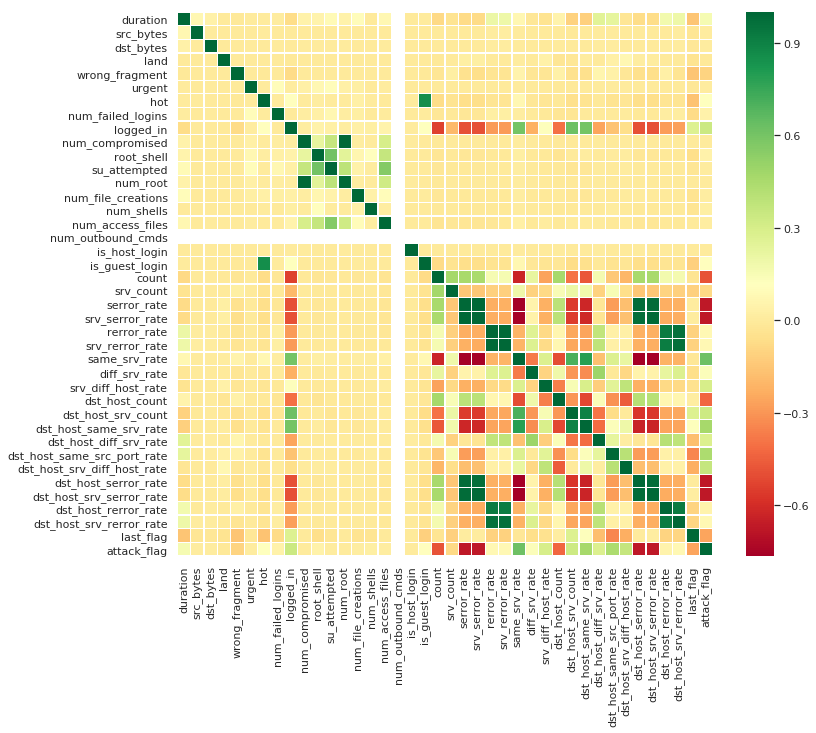

In [16]:
# multi-collinearity check
sns.set(style='whitegrid')
plt.figure(figsize=(12,10))
cormat=train.corr()
sns.heatmap(cormat,linewidth=.2,cmap='RdYlGn')

* the feature "num_outbound_cmds" has only 0 as its entries, hence can be removed.
* many network time related traffic features are correlated among each other
* logged in is correlated to many network time related features too.

In [17]:
print(train['num_outbound_cmds'].value_counts())
train.drop(columns=['num_outbound_cmds'],inplace=True)

0    125973
Name: num_outbound_cmds, dtype: int64


In [18]:
print(len(train.service.value_counts()))

70


In [19]:
#finding the top services from a total of 70 different services.
train.service.value_counts()[0:11]

http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
eco_i        4586
other        4359
ecr_i        3077
telnet       2353
finger       1767
ftp          1754
Name: service, dtype: int64

In [20]:
# reducing no. of categories in service by combining low freq. categories into "other"
cond=((train.service=='http')|(train.service=='private')|(train.service=='domain_u')|(train.service=='smtp')|(train.service=='ftp_data')|(train.service=='eco_i')|
     (train.service=='ecr_i')|(train.service=='telnet')|(train.service=='finger')|(train.service=='ftp')|(train.service=='other'))

train['service_n']=train['service'].where(cond,'new_others')

* service_n has 12 diff. categories, checking if it has any relation to attack_flag using chi2-test
* H0 : no relation b/w Service_n & attack_flag
* H1 : relation exists b/w Service_n & attack_flag 

In [21]:
t=pd.crosstab(train['service_n'],train['attack_flag'],margins=True)
stats.chi2_contingency(observed=t)       

(151404.87676599354,
 0.0,
 60,
 array([[3.29687997e+03, 4.83423233e+03, 8.36728569e+02, 7.14262977e+01,
         3.73283164e+00, 9.04300000e+03],
        [1.67195528e+03, 2.45159675e+03, 4.24332325e+02, 3.62226033e+01,
         1.89304057e+00, 4.58600000e+03],
        [1.12180689e+03, 1.64491130e+03, 2.84707929e+02, 2.43037397e+01,
         1.27014519e+00, 3.07700000e+03],
        [6.44209545e+02, 9.44607821e+02, 1.63496559e+02, 1.39566812e+01,
         7.29394394e-01, 1.76700000e+03],
        [6.39470029e+02, 9.37658244e+02, 1.62293698e+02, 1.38540005e+01,
         7.24028165e-01, 1.75400000e+03],
        [2.50100593e+03, 3.66723806e+03, 6.34740460e+02, 5.41838330e+01,
         2.83171791e+00, 6.86000000e+03],
        [1.47063524e+04, 2.15640013e+04, 3.73238494e+03, 3.18610417e+02,
         1.66509966e+01, 4.03380000e+04],
        [8.26498607e+03, 1.21189922e+04, 2.09760441e+03, 1.79059402e+02,
         9.35787828e+00, 2.26700000e+04],
        [1.58919604e+03, 2.33024646e+03, 4.03328

 * Since p-value < alpha(0.05), with 95% conf. Null-Hypo rejected, hence relation exists

In [22]:
#dropping the redundant columns now
train.drop(columns=['attack','service'],inplace=True)

In [23]:
train.select_dtypes(include='object').describe().T

,count,unique,top,freq
protocol_type,125973,3,tcp,102689
flag,125973,11,SF,74945
service_n,125973,12,http,40338


In [24]:
# UDF for getting dummy vars.
def dums(df):
    df=pd.get_dummies(df,drop_first=True,prefix='dum')
    return df

In [25]:
dum_vars=dums(train.select_dtypes(include='object'))

In [26]:
dum_vars.head(1)

,dum_tcp,dum_udp,dum_REJ,dum_RSTO,dum_RSTOS0,dum_RSTR,dum_S0,dum_S1,dum_S2,dum_S3,...,dum_ecr_i,dum_finger,dum_ftp,dum_ftp_data,dum_http,dum_new_others,dum_other,dum_private,dum_smtp,dum_telnet
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [27]:
print('train dimensions :',train.shape)
print('dummy vars. dimension :',dum_vars.shape)

train dimensions : (125973, 42)
dummy vars. dimension : (125973, 23)


In [28]:
train_new=pd.concat([train,dum_vars],axis=1)
train_new.drop(columns=['protocol_type','flag','service_n'],inplace=True)
print('new train dimensions :',train_new.shape)

new train dimensions : (125973, 62)


In [29]:
train_new.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dum_ecr_i,dum_finger,dum_ftp,dum_ftp_data,dum_http,dum_new_others,dum_other,dum_private,dum_smtp,dum_telnet
0,0,491,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,146,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,232,8153,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,0,199,420,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


* Scaling the data for ease of training and prediction (scaling helps in achieving faster gradient descent)

In [30]:
mm= MinMaxScaler()
at=train_new['attack_flag']  #we don't want to scale the multiclass target, hence assign to a new series and drop it
train_new.drop(columns=['attack_flag'],inplace=True)
train_scaled=mm.fit_transform(train_new)

In [31]:
train_scaled.shape

(125973, 61)

In [32]:
# new new train here
train_new=pd.DataFrame(data=train_scaled,columns=train_new.columns)
train_new=pd.concat([train_new,at],axis=1) #concat the target column
print(train_new.shape)

(125973, 62)


In [33]:
train_new.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dum_finger,dum_ftp,dum_ftp_data,dum_http,dum_new_others,dum_other,dum_private,dum_smtp,dum_telnet,attack_flag
0,0.0,3.558064e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
2,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,0.0,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


## ML Modelling

In [34]:
feature_cols=train_new.columns.difference(['attack_flag'])
feature_cols

Index(['count', 'diff_srv_rate', 'dst_bytes', 'dst_host_count',
       'dst_host_diff_srv_rate', 'dst_host_rerror_rate',
       'dst_host_same_src_port_rate', 'dst_host_same_srv_rate',
       'dst_host_serror_rate', 'dst_host_srv_count',
       'dst_host_srv_diff_host_rate', 'dst_host_srv_rerror_rate',
       'dst_host_srv_serror_rate', 'dum_REJ', 'dum_RSTO', 'dum_RSTOS0',
       'dum_RSTR', 'dum_S0', 'dum_S1', 'dum_S2', 'dum_S3', 'dum_SF', 'dum_SH',
       'dum_eco_i', 'dum_ecr_i', 'dum_finger', 'dum_ftp', 'dum_ftp_data',
       'dum_http', 'dum_new_others', 'dum_other', 'dum_private', 'dum_smtp',
       'dum_tcp', 'dum_telnet', 'dum_udp', 'duration', 'hot', 'is_guest_login',
       'is_host_login', 'land', 'last_flag', 'logged_in', 'num_access_files',
       'num_compromised', 'num_failed_logins', 'num_file_creations',
       'num_root', 'num_shells', 'rerror_rate', 'root_shell', 'same_srv_rate',
       'serror_rate', 'src_bytes', 'srv_count', 'srv_diff_host_rate',
       'srv_rerror

In [35]:
# train-test split
train_x, test_x, train_y, test_y = train_test_split(train_new[feature_cols], train_new['attack_flag'], test_size=.3, random_state=12345)
print('train_X :',train_x.shape)
print('train_y :',train_y.shape)
print('test_x :',test_x.shape)
print('test_y :',test_y.shape)

train_X : (88181, 61)
train_y : (88181,)
test_x : (37792, 61)
test_y : (37792,)


### Logistic Regression

In [36]:
# LOGISTIC REGRESSION
logreg=LogisticRegression()
model1=logreg.fit(train_x,train_y)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [37]:
pd.DataFrame({'Features':train_x.columns,'Coefs':model1.coef_[0]}).sort_values(by='Coefs',ascending=False).head(10)

,Features,Coefs
60,wrong_fragment,12.568531
24,dum_ecr_i,10.812860
56,srv_rerror_rate,7.051245
17,dum_S0,5.277638
54,srv_count,5.149891
8,dst_host_serror_rate,5.110095
7,dst_host_same_srv_rate,4.691629
37,hot,4.644205
57,srv_serror_rate,4.604908
5,dst_host_rerror_rate,3.897557


In [38]:
proba_train=pd.DataFrame(model1.predict_proba(train_x),columns=['pred_0','pred_1','pred_2','pred_3','pred_4'])
train_pred=pd.DataFrame({'actual':train_y,'predicted':model1.predict(train_x)})
train_pred=train_pred.reset_index()

train_pred_df=pd.concat([train_pred,proba_train],axis=1)
train_pred_df.head(3)

,index,actual,predicted,pred_0,pred_1,pred_2,pred_3,pred_4
0,91284,0,0,0.725317,0.274390,3.051381e-07,0.000091,0.000202
1,120904,0,0,0.999796,0.000101,7.897322e-05,0.000018,0.000007
2,35391,1,1,0.011846,0.988102,3.233470e-09,0.000040,0.000012


In [39]:
proba_test=pd.DataFrame(model1.predict_proba(test_x),columns=['pred_0','pred_1','pred_2','pred_3','pred_4'])
test_pred=pd.DataFrame({'actual':test_y,'predicted':model1.predict(test_x)})
test_pred=test_pred.reset_index()
test_pred_df=pd.concat([test_pred,proba_test],axis=1)
test_pred_df.head(3)

,index,actual,predicted,pred_0,pred_1,pred_2,pred_3,pred_4
0,112168,0,0,0.970402,0.022851,6.701910e-03,0.000030,0.000014
1,66607,1,1,0.012252,0.987696,3.501433e-09,0.000039,0.000012
2,108068,0,0,0.917296,0.082582,1.681997e-05,0.000003,0.000103


In [40]:
# model 1 evaluation metrics
model1_tr_accu=metrics.accuracy_score(train_pred_df['actual'],train_pred_df['predicted'])
model1_te_accu=metrics.accuracy_score(test_pred_df['actual'],test_pred_df['predicted'])

### Decision Trees

In [41]:
# DECISION TREE
dt=DecisionTreeClassifier(random_state=12345)
para=[{'max_depth':[18,19,20],
      'max_features':[24,25,26]}]
grid1=GridSearchCV(dt, param_grid=para, cv=5, scoring='accuracy',n_jobs=-1)

In [42]:
grid1.fit(train_x,train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=12345,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid=[{'max_depth': [18, 19, 20],
                          'max_features': [24, 25, 26]}],
             pre_dispatch=

In [43]:
grid1.best_params_

{'max_depth': 18, 'max_features': 26}

In [44]:
dt_model=DecisionTreeClassifier(max_depth=19, max_features=25, random_state=12345)
dt_model=dt_model.fit(train_x,train_y)

In [45]:
dt_train_pred=dt_model.predict(train_x)
dt_test_pred=dt_model.predict(test_x)

In [46]:
# decision tree evaluation metrics
dt_tr_ac=metrics.accuracy_score(train_y,dt_train_pred)
dt_te_ac=metrics.accuracy_score(test_y,dt_test_pred)

### Random Forests

In [47]:
# randomforest classifier
bg=RandomForestClassifier(random_state=12345)
para=[{'max_features':[21,22,23],
      'n_estimators':[50,60,70]}]
grid2=GridSearchCV(bg,param_grid=para,cv=5, n_jobs=-1)

In [48]:
grid2.fit(train_x,train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=12345, verbose=0,
                                              warm_start=False),
             ii

In [49]:
grid2.best_params_

{'max_features': 21, 'n_estimators': 50}

In [50]:
rf_model=RandomForestClassifier(max_features=21, n_estimators=50, random_state=12345, n_jobs=-1)
rf_model=rf_model.fit(train_x,train_y)

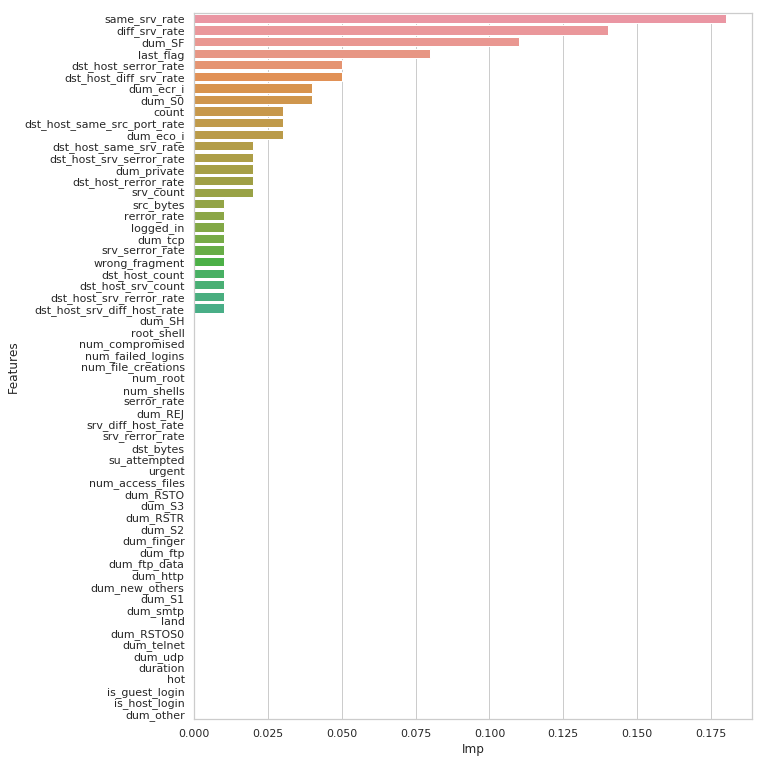

In [51]:
plt.figure(figsize=(10,13))
rf_imp_fet=pd.DataFrame({'Features':train_x.columns, 'Imp':rf_model.feature_importances_.round(2)})
rf_imp_fet=rf_imp_fet.sort_values(by='Imp',ascending=False)
sns.barplot(y=rf_imp_fet['Features'],x=rf_imp_fet['Imp'])

In [52]:
rf_train_pred=rf_model.predict(train_x)
rf_test_pred=rf_model.predict(test_x)

In [53]:
# random forest evaluation metrics
rf_tr_ac=metrics.accuracy_score(train_y, rf_train_pred)
rf_te_ac=metrics.accuracy_score(test_y, rf_test_pred)

## Model Evaluation

In [54]:
eva_train_df=pd.DataFrame(columns=['Accuracy'], index=['LogReg','D.Trees','RandomForest'], data=[model1_tr_accu, dt_tr_ac, rf_tr_ac])
eva_test_df=pd.DataFrame(columns=['Accuracy'], index=['LogReg','D.Trees','RandomForest'], data=[model1_te_accu, dt_te_ac, rf_te_ac])

In [55]:
eva_train_df

,Accuracy
LogReg,0.988886
D.Trees,0.999739
RandomForest,0.999989


In [56]:
eva_test_df

,Accuracy
LogReg,0.987802
D.Trees,0.997777
RandomForest,0.999286


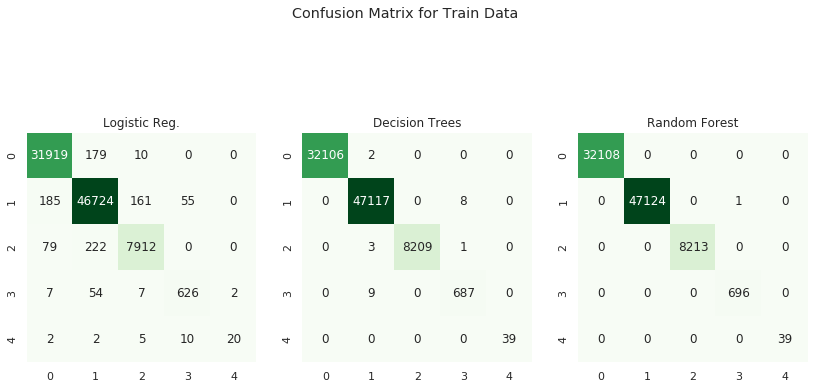

In [57]:
f,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(14,7))
f.suptitle('Confusion Matrix for Train Data')
ax1.set_title('Logistic Reg.')
sns.heatmap(metrics.confusion_matrix(train_y,train_pred_df['predicted']),fmt='d',annot=True,ax=ax1,square=True,cbar=False,cmap='Greens')
ax2.set_title('Decision Trees')
sns.heatmap(metrics.confusion_matrix(train_y,dt_train_pred),fmt='d',annot=True,ax=ax2,square=True,cbar=False,cmap='Greens')
ax3.set_title('Random Forest')
sns.heatmap(metrics.confusion_matrix(train_y,rf_train_pred),fmt='d',annot=True,ax=ax3,square=True,cbar=False,cmap='Greens')

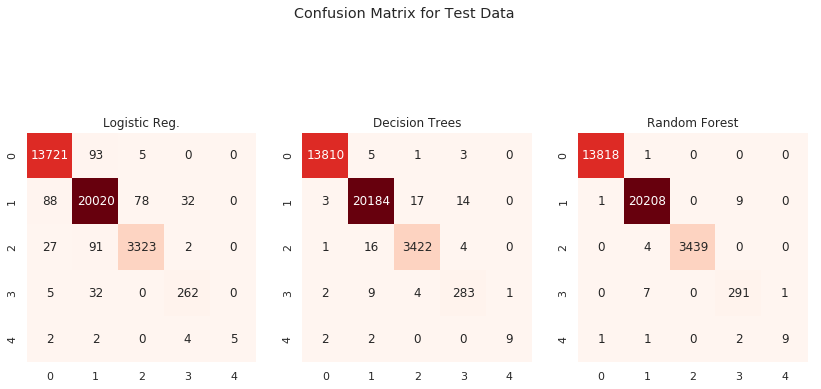

In [58]:
f,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(14,7))
f.suptitle('Confusion Matrix for Test Data')
ax1.set_title('Logistic Reg.')
sns.heatmap(metrics.confusion_matrix(test_y,test_pred_df['predicted']),fmt='d',annot=True,ax=ax1,square=True,cbar=False,cmap='Reds')
ax2.set_title('Decision Trees')
sns.heatmap(metrics.confusion_matrix(test_y,dt_test_pred),fmt='d',annot=True,ax=ax2,square=True,cbar=False,cmap='Reds')
ax3.set_title('Random Forest')
sns.heatmap(metrics.confusion_matrix(test_y,rf_test_pred),fmt='d',annot=True,ax=ax3,square=True,cbar=False,cmap='Reds')

#### Evaluating Heatmap Scores
* As clear from heatmaps of both train and test data all 3 models are able to predict max number of class0 as class0, max number of class1 as class1 & so on.
* The number of false predictions are low across all the 3 models, with the least in Random Forest Model(best model).

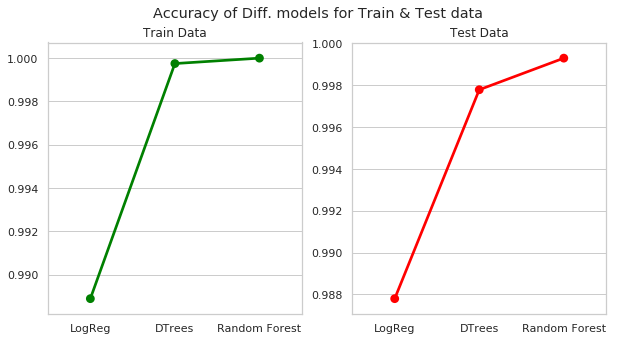

In [59]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
f.suptitle('Accuracy of Diff. models for Train & Test data')
ax1.set_title('Train Data')
sns.pointplot(x=['LogReg','DTrees','Random Forest'], y=eva_train_df.Accuracy.to_list(),data=eva_train_df,ax=ax1, color='green')
ax2.set_title('Test Data')
sns.pointplot(x=['LogReg','DTrees','Random Forest'], y=eva_test_df.Accuracy.to_list(),data=eva_test_df,ax=ax2, color='red')
#eva_train_df.iloc[0]

* Since Random Forest model, with parameters (max_features=21, n_estimators=50) gave the highest accuracy, it shall be used to classify attack class in the future.

~ ~ END ~ ~
* C.Varun